In [2]:
import matplotlib.gridspec as gridspec
import scqubits
import numpy as np
from CoupledQuantumSystems.visualization import *
from CoupledQuantumSystems.systems import *
from tqdm import tqdm
from CoupledQuantumSystems.qobj_manip import *
from CoupledQuantumSystems.drive import *
from  IPython.display import  clear_output

In [16]:
max_ql = 13
max_tl = 4
EJ = 3
EC = EJ/4
EL = EJ/20.5
fluxonium = scqubits.Fluxonium(EJ = EJ,EC = EC,EL = EL, cutoff = 110,flux = 0,truncated_dim=max_ql)

Er loop: 100%|██████████| 10000/10000 [00:00<00:00, 151728.40it/s]


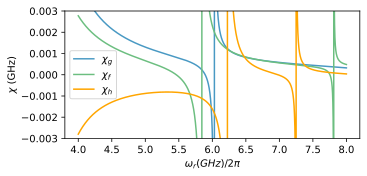

In [63]:
n_evals = 13
qls = [0,2,3]
colors = ['#4999c3','#6cbe80','orange']
labels = [r'$\chi_g$',r'$\chi_f$',r'$\chi_h$']


evals1 = fluxonium.eigenvals(n_evals)
matrix1 =  fluxonium.matrixelement_table(operator = "n_operator",evals_count=n_evals)
def get_shift_accurate(ele,omega_i, omega_j, omega_r):
    return abs(ele)**2 / (omega_j-omega_i-omega_r) - abs(ele)**2 / (omega_i-omega_j-omega_r)


fig = plt.figure(figsize=(5, 2.3)) 
gs = fig.add_gridspec(1,1,left=0.17,right=0.99,bottom=0.18,top=0.95)
ax1 = fig.add_subplot(gs[0])
Er_list1 = np.linspace(4,8,int(1e4))
for ql, label, color in zip(qls, labels, colors):
    shift_from_qubit_transition = []
    for Er in tqdm(Er_list1, desc = "Er loop"):
        shifts = [get_shift_accurate(matrix1[ql,ql2], evals1[ql2], evals1[ql], Er) for ql2 in range(n_evals)] 
        shift_from_qubit_transition.append(sum(shifts)/100)
    ax1.plot(Er_list1,np.array(shift_from_qubit_transition), label= label,color = color)

ax1.set_ylim(-0.003,0.003)
ax1.set_xlabel(rf"$\omega_r (GHz)/2\pi$")
ax1.set_ylabel(rf"$\chi$ (GHz)")
ax1.legend()
fig.savefig('shift_from_qubit_transmon.pdf')

In [24]:
evals  = fluxonium.eigenvals(20)
for i in [4,6,8,10,12,14,16]:
    print(f"3-{i} freq: {evals[i]-evals[3]}")

3-4 freq: 1.874076299643864
3-6 freq: 3.6184356520917875
3-8 freq: 6.225391402876429
3-10 freq: 7.250230991711067
3-12 freq: 8.924775356667507
3-14 freq: 10.774476734129543
3-16 freq: 12.782055021165233


In [26]:
transmon = scqubits.Transmon(EJ = 34.74,EC=0.2,ng=0,ncut=10)
transmon.eigenvals(3)[1]-transmon.eigenvals(3)[0]

7.2496831775422415

In [25]:
def find_tmon_EJ(freq):
    def objective(x):
        EJ = x[0]
        transmon = scqubits.Transmon(EJ = EJ,EC=0.2,ng=0,ncut=10)
        return abs(transmon.eigenvals(3)[1]-transmon.eigenvals(3)[0]-freq)
    from scipy.optimize import minimize
    result = minimize(objective,[30],method='Nelder-Mead')
    return result.x[0]

find_tmon_EJ(6.225391402876429)

25.858154296875

In [43]:
from scipy.optimize import minimize

def objective(x):
    
    EJ = x[0]
    amp = x[1]
    t_duration = x[2]
    tlist = np.linspace(0,t_duration,1000)

    transmon = scqubits.Transmon(
        EJ= EJ,
        EC=0.2,
        ng=0.0,
        ncut=10,
        truncated_dim = max_tl
        )

    system = FluxoniumTransmonSystem(
        fluxonium  = fluxonium,
        transmon = transmon,
        computaional_states = '0,2',
        g_strength = 0.1,
        )
    driven_op = qutip.Qobj(system.hilbertspace.op_in_dressed_eigenbasis(transmon.n_operator)[:, :])

    e_ops = []
    for ql in range(max_ql):
        for tl in range(max_tl):
            e_ops.append(system.truncate_function(qutip.ket2dm(qutip.basis(system.hilbertspace.dimension, system.product_to_dressed[(ql,tl)]))))

    results  = system.run_qutip_mesolve_parrallel(
        initial_states = [qutip.basis(system.hilbertspace.dimension, system.product_to_dressed[(ql,0)]) for ql in [0,2,3]],
        tlist = tlist,
        drive_terms = [DriveTerm( 
                            driven_op= driven_op,
                            pulse_shape_func=square_pulse_with_rise_fall,
                            pulse_id = 'sdaas',
                            pulse_shape_args={
                                'w_d': system.evals[system.product_to_dressed[(3,1)]] - system.evals[system.product_to_dressed[(3,0)]] ,
                                'amp': amp,
                                't_square': 1000
                            })],
        # c_ops = c_ops,
        e_ops =  e_ops
    )
    
    fig, axes = plt.subplots(1,3,figsize = (15,5))
    for i, (result,ql) in enumerate(zip(results,[0,2,3])):
        axes[i].plot(tlist,result.expect[ql*max_tl+0],label= rf"$\langle${ql}$_f0_t\rangle$")
        axes[i].plot(tlist,result.expect[ql*max_tl+1],label= rf"$\langle${ql}$_f1_t\rangle$")
        axes[i].plot(tlist,result.expect[ql*max_tl+2],label= rf"$\langle${ql}$_f2_t\rangle$")
        axes[i].legend()
        axes[i].set_yscale('log')
        axes[i].set_ylim(1e-4,1+2)
    clear_output()
    plt.show()
    obj =  -results[0].expect[0*max_tl+0][-1] ** 2 \
            -results[1].expect[2*max_tl+0][-1] ** 2\
            + results[2].expect[3*max_tl+0][-1] ** 2 / 50
    print(f"x = {x}, obj  = {obj}")
    return obj


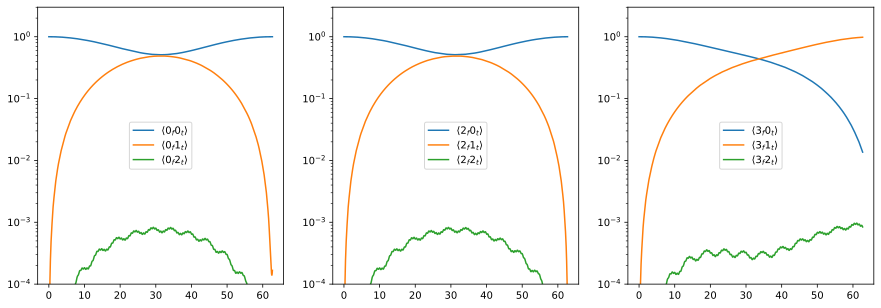

x = [3.47448544e+01 7.38495013e-03 6.27129965e+01], obj  = -1.9995773337425868
 Total run time:   0.81s ] Elapsed 0.84s / Remaining 00:00:00:00 [*********91%*********  ] Elapsed 0.80s / Remaining 00:00:00:00
 Total run time:   0.86s ] Elapsed 0.83s / Remaining 00:00:00:00 [*********99%***********] Elapsed 0.86s / Remaining 00:00:00:00
 Total run time:   0.86s*] Elapsed 0.86s / Remaining 00:00:00:00


Processing states with pad_back_custom: 100%|██████████| 1000/1000 [00:00<00:00, 9425.40it/s]


KeyboardInterrupt: 

In [44]:
initial_guess = [34.75152,  0.0469  / (2*np.pi), 62.72]
 
result = minimize(objective, initial_guess,bounds = [(34.74,34.76),(0.046/ (2*np.pi),0.0475/ (2*np.pi)),(62,63.5)], method='L-BFGS-B')

objective(initial_guess)

In [ ]:
x = [3.47448874e+01 7.38361973e-03 6.27130311e+01], obj  = -1.9995792649333173


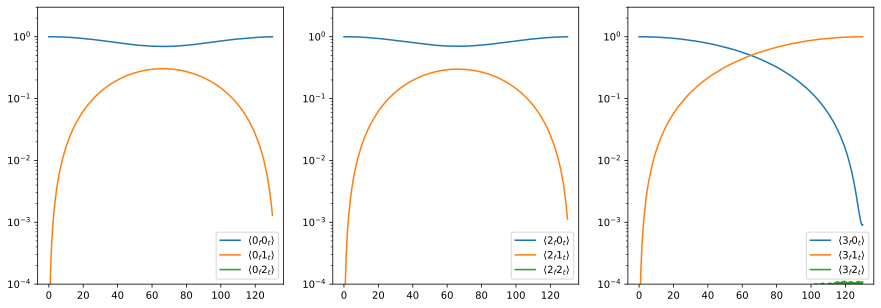

x = [26.25455, 0.0029527539127010066, 130.0], obj  = -1.99516338437595


-1.99516338437595

In [37]:
initial_guess = [26.25455,  0.0185527  / (2*np.pi), 130.0]
 
result = minimize(objective, initial_guess,bounds = [(26.24,26.27),(0.018/ (2*np.pi),0.019/ (2*np.pi)),(128,132)], method='L-BFGS-B')

objective(initial_guess)

In [ ]:
x = [2.62458601e+01 2.99734504e-03 1.30003243e+02], obj  = -1.9998733770101937

 Total run time:   0.82s*] Elapsed 0.82s / Remaining 00:00:00:00 [*********92%*********  ] Elapsed 0.78s / Remaining 00:00:00:00 [*********53%           ] Elapsed 0.38s / Remaining 00:00:00:00
 Total run time:   0.83s*] Elapsed 0.83s / Remaining 00:00:00:00 [*********96%********** ] Elapsed 0.81s / Remaining 00:00:00:00
 Total run time:   0.84s*] Elapsed 0.84s / Remaining 00:00:00:00
 Total run time:   0.85s*] Elapsed 0.85s / Remaining 00:00:00:00


Processing states with pad_back_custom: 100%|██████████| 1000/1000 [00:00<00:00, 8501.46it/s]


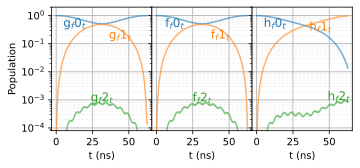

In [50]:
x =  [3.47448874e+01 ,7.38361973e-03, 6.27130311e+01]


EJ = x[0]
amp = x[1]
t_duration = x[2]
tlist = np.linspace(0,t_duration,1000)

transmon = scqubits.Transmon(
    EJ= EJ,
    EC=0.2,
    ng=0.0,
    ncut=10,
    truncated_dim = max_tl
    )

system = FluxoniumTransmonSystem(
    fluxonium  = fluxonium,
    transmon = transmon,
    computaional_states = '0,2',
    g_strength = 0.1,
    )
driven_op = qutip.Qobj(system.hilbertspace.op_in_dressed_eigenbasis(transmon.n_operator)[:, :])

e_ops = []
for ql in range(max_ql):
    for tl in range(max_tl):
        e_ops.append(system.truncate_function(qutip.ket2dm(qutip.basis(system.hilbertspace.dimension, system.product_to_dressed[(ql,tl)]))))

results  = system.run_qutip_mesolve_parrallel(
    initial_states = [qutip.basis(system.hilbertspace.dimension, system.product_to_dressed[(ql,0)]) for ql in [0,2,3,1]],
    tlist = tlist,
    drive_terms = [DriveTerm( 
                        driven_op= driven_op,
                        pulse_shape_func=square_pulse_with_rise_fall,
                        pulse_id = 'sdaas',
                        pulse_shape_args={
                            'w_d': system.evals[system.product_to_dressed[(3,1)]] - system.evals[system.product_to_dressed[(3,0)]] ,
                            'amp': amp,
                            't_square': 1000
                        })],
    # c_ops = c_ops,
    e_ops =  e_ops
)
import matplotlib.ticker as ticker

fig = plt.figure(figsize=(5, 2.3)) 
bottom = 0.2
top = 0.95
left = 0.15
l = 0.28

gs0 = fig.add_gridspec(nrows=1, ncols=1,left=left, right=left+l,
                       bottom=bottom,top = top)
gs1 = fig.add_gridspec(nrows=1, ncols=1,left=left+l, right=left+l*2,
                       bottom=bottom,top = top)
gs2 = fig.add_gridspec(nrows=1, ncols=1,left=left+l*2, right=left+l*3,
                       bottom=bottom,top = top)

axes = [fig.add_subplot(gs0[0]),
        fig.add_subplot(gs1[0]),
        fig.add_subplot(gs2[0])]

alpha=0.6
for i, (result,ql,ql_label) in enumerate(zip(results,[0,2,3],['g','f','h'])):
    line, =axes[i].plot(tlist,result.expect[ql*max_tl+0],label= rf"$\langle${ql_label}$_f0_t\rangle$",alpha=alpha)
    axes[i].text(tlist[200],result.expect[ql*max_tl+0][200],s= rf"{ql_label}$_f0_t$",va='top',ha='center',color=line.get_color(),size=12)

    line, =axes[i].plot(tlist,result.expect[ql*max_tl+1],label= rf"$\langle${ql_label}$_f1_t\rangle$",alpha=alpha)
    axes[i].text(tlist[-300],result.expect[ql*max_tl+1][-300],s= rf"{ql_label}$_f1_t$",va='top',ha='center',color=line.get_color(),size=12)

    line, =axes[i].plot(tlist,result.expect[ql*max_tl+2],label= rf"$\langle${ql_label}$_f2_t\rangle$",alpha=alpha)
    if i == 0 or i ==1:
        axes[i].text(tlist[-500],result.expect[ql*max_tl+2][-500],s= rf"{ql_label}$_f2_t$",va='bottom',ha='center',color=line.get_color(),size=12)
    else:
        axes[i].text(tlist[-100],result.expect[ql*max_tl+2][-100],s= rf"{ql_label}$_f2_t$",va='bottom',ha='center',color=line.get_color(),size=12)

    axes[i].set_yscale('log')
    axes[i].set_ylim(8e-5,2)

    # Major and minor ticks for logarithmic scale
    axes[i].yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=10))  # Set major ticks
    axes[i].yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs='auto', numticks=10))  # Set minor ticks

    axes[i].grid(which='major', linestyle='-')  # Solid grid lines for major ticks
    axes[i].grid(which='minor', linestyle='--',alpha=0.2)  # Dashed grid lines for minor ticks

for i in [0,1,2]:
    axes[i].set_xlabel(f"t (ns)")
axes[0].set_ylabel('Population')
axes[1].set_ylabel('')
axes[1].set_yticklabels([])
axes[2].set_ylabel('')
axes[2].set_yticklabels([])

plt.show()
fig.savefig('detect3_6.2GHz.pdf')

 Total run time:   0.95s ] Elapsed 0.95s / Remaining 00:00:00:00 [*********99%***********] Elapsed 0.94s / Remaining 00:00:00:00
 Total run time:   0.99s*] Elapsed 0.99s / Remaining 00:00:00:00 [*********94%********** ] Elapsed 0.99s / Remaining 00:00:00:00
 [*********98%***********] Elapsed 1.00s / Remaining 00:00:00:000[*********97%********** ] Elapsed 0.99s / Remaining 00:00:00:00

Processing states with pad_back_custom: 100%|██████████| 1000/1000 [00:00<00:00, 9207.24it/s]


 Total run time:   1.02s*] Elapsed 1.02s / Remaining 00:00:00:00
 Total run time:   1.05s*] Elapsed 1.05s / Remaining 00:00:00:00


Processing states with pad_back_custom: 100%|██████████| 1000/1000 [00:00<00:00, 9483.00it/s]


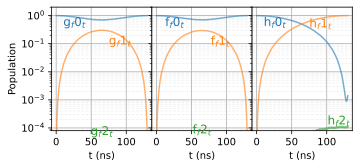

In [51]:
x = [2.62458601e+01 ,2.99734504e-03,1.30003243e+02]


EJ = x[0]
amp = x[1]
t_duration = x[2]
tlist = np.linspace(0,t_duration,1000)

transmon = scqubits.Transmon(
    EJ= EJ,
    EC=0.2,
    ng=0.0,
    ncut=10,
    truncated_dim = max_tl
    )

system = FluxoniumTransmonSystem(
    fluxonium  = fluxonium,
    transmon = transmon,
    computaional_states = '0,2',
    g_strength = 0.1,
    )
driven_op = qutip.Qobj(system.hilbertspace.op_in_dressed_eigenbasis(transmon.n_operator)[:, :])

e_ops = []
for ql in range(max_ql):
    for tl in range(max_tl):
        e_ops.append(system.truncate_function(qutip.ket2dm(qutip.basis(system.hilbertspace.dimension, system.product_to_dressed[(ql,tl)]))))

results  = system.run_qutip_mesolve_parrallel(
    initial_states = [qutip.basis(system.hilbertspace.dimension, system.product_to_dressed[(ql,0)]) for ql in [0,2,3,1]],
    tlist = tlist,
    drive_terms = [DriveTerm( 
                        driven_op= driven_op,
                        pulse_shape_func=square_pulse_with_rise_fall,
                        pulse_id = 'sdaas',
                        pulse_shape_args={
                            'w_d': system.evals[system.product_to_dressed[(3,1)]] - system.evals[system.product_to_dressed[(3,0)]] ,
                            'amp': amp,
                            't_square': 1000
                        })],
    # c_ops = c_ops,
    e_ops =  e_ops
)

import matplotlib.ticker as ticker

fig = plt.figure(figsize=(5, 2.3)) 
bottom = 0.2
top = 0.95
left = 0.15
l = 0.28

gs0 = fig.add_gridspec(nrows=1, ncols=1,left=left, right=left+l,
                       bottom=bottom,top = top)
gs1 = fig.add_gridspec(nrows=1, ncols=1,left=left+l, right=left+l*2,
                       bottom=bottom,top = top)
gs2 = fig.add_gridspec(nrows=1, ncols=1,left=left+l*2, right=left+l*3,
                       bottom=bottom,top = top)

axes = [fig.add_subplot(gs0[0]),
        fig.add_subplot(gs1[0]),
        fig.add_subplot(gs2[0])]

alpha=0.6
for i, (result,ql,ql_label) in enumerate(zip(results,[0,2,3],['g','f','h'])):
    line, =axes[i].plot(tlist,result.expect[ql*max_tl+0],label= rf"$\langle${ql_label}$_f0_t\rangle$",alpha=alpha)
    axes[i].text(tlist[200],result.expect[ql*max_tl+0][200],s= rf"{ql_label}$_f0_t$",va='top',ha='center',color=line.get_color(),size=12)

    line, =axes[i].plot(tlist,result.expect[ql*max_tl+1],label= rf"$\langle${ql_label}$_f1_t\rangle$",alpha=alpha)
    axes[i].text(tlist[-300],result.expect[ql*max_tl+1][-300],s= rf"{ql_label}$_f1_t$",va='top',ha='center',color=line.get_color(),size=12)

    line, =axes[i].plot(tlist,result.expect[ql*max_tl+2],label= rf"$\langle${ql_label}$_f2_t\rangle$",alpha=alpha)
    if i == 0 or i ==1:
        axes[i].text(tlist[-500],result.expect[ql*max_tl+2][-500],s= rf"{ql_label}$_f2_t$",va='bottom',ha='center',color=line.get_color(),size=12)
    else:
        axes[i].text(tlist[-100],result.expect[ql*max_tl+2][-100],s= rf"{ql_label}$_f2_t$",va='bottom',ha='center',color=line.get_color(),size=12)

    axes[i].set_yscale('log')
    axes[i].set_ylim(8e-5,2)

    # Major and minor ticks for logarithmic scale
    axes[i].yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=10))  # Set major ticks
    axes[i].yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs='auto', numticks=10))  # Set minor ticks

    axes[i].grid(which='major', linestyle='-')  # Solid grid lines for major ticks
    axes[i].grid(which='minor', linestyle='--',alpha=0.2)  # Dashed grid lines for minor ticks

for i in [0,1,2]:
    axes[i].set_xlabel(f"t (ns)")
axes[0].set_ylabel('Population')
axes[1].set_ylabel('')
axes[1].set_yticklabels([])
axes[2].set_ylabel('')
axes[2].set_yticklabels([])

plt.show()
fig.savefig('detect3.pdf')